In [ ]:
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression

# **An Exploration of Forecasting**
This notebook serves as a playground to teach myself forecasting techniques.

## **Data Loading**

### **Imports**

In [ ]:
class cartoApi:

    def __init__(self,query,format = "CSV") -> None:
        self.base              = "https://phl.carto.com/api/v2/sql?q="
        self.query             = query
        self.format            = format
        self.request_plain     = f"{self.base}{self.query}&format={self.format}"
        self.request_url       = f"{self.base}{urllib.parse.quote_plus(self.query)}&format={self.format}"

    def queryRequest(self):
        request = requests.get(self.request_url)
        return request.content

    def queryDataframe(self):
        data = pd.read_csv(self.request_url)
        return(data)

In [ ]:
#shootings      = SELECT * FROM shootings WHERE date_ >= '1/1/2020'
#threeOneOne    = SELECT * FROM public_cases_fc WHERE requested_datetime >= '1/1/2020'

api_call = cartoApi(query="SELECT * FROM shootings WHERE date_ >= '1/1/2020'")
df = api_call.queryDataframe()
#df.head(10)

In [ ]:
print(len(df.index))
df["date_only"] = pd.to_datetime(df["date_"]).dt.date
#print(df["date_only"].head(10))

9468


In [ ]:
grouped = df.groupby(by="date_only").count()
grouped.reset_index(inplace=True)
grouped = grouped[["date_only", "the_geom"]].rename(columns={"the_geom":"count"})
grouped.head()

,date_only,count
0,2020-01-01,6
1,2020-01-02,2
2,2020-01-03,2
3,2020-01-04,4
4,2020-01-06,1


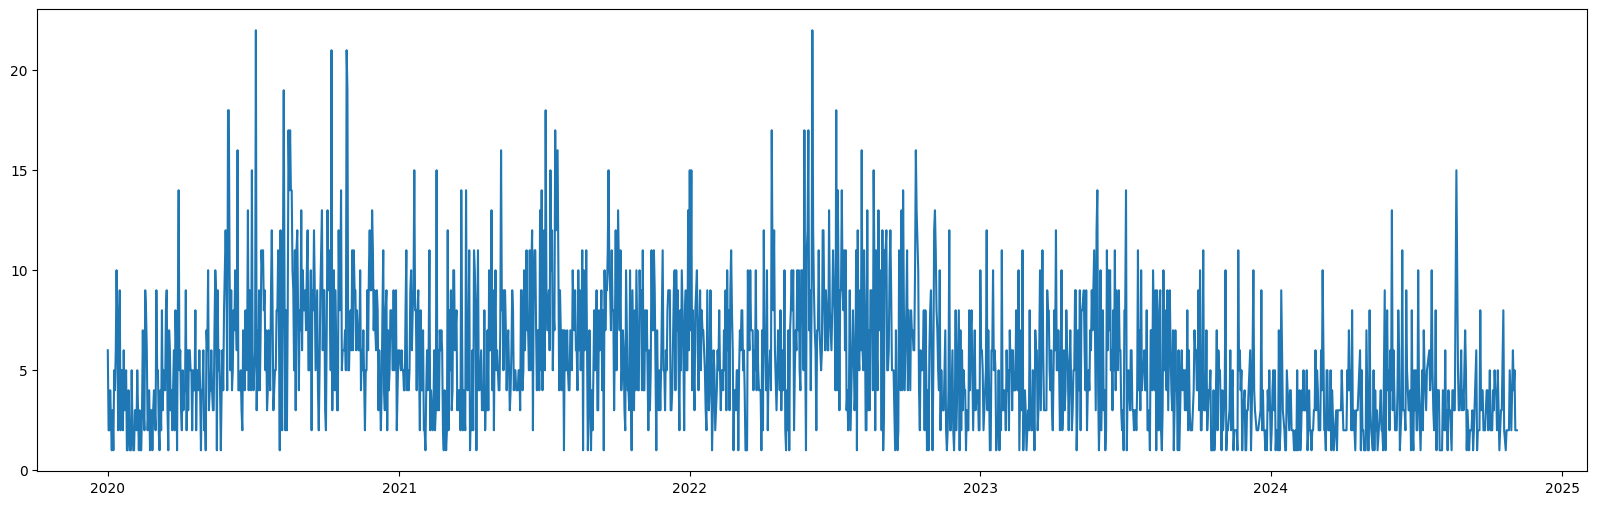

In [ ]:
plt.subplots(figsize=(20, 6))
plt.plot(grouped["date_only"], grouped["count"])
plt.show()

## **Visualizing and Trend Hunting**
In this section we will attempt to uncover any trends behing the madness of violent crime.

In [ ]:
# annotations: https://stackoverflow.com/a/49238256/5769929
# code borrowed from https://www.kaggle.com/code/ryanholbrook/trend
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

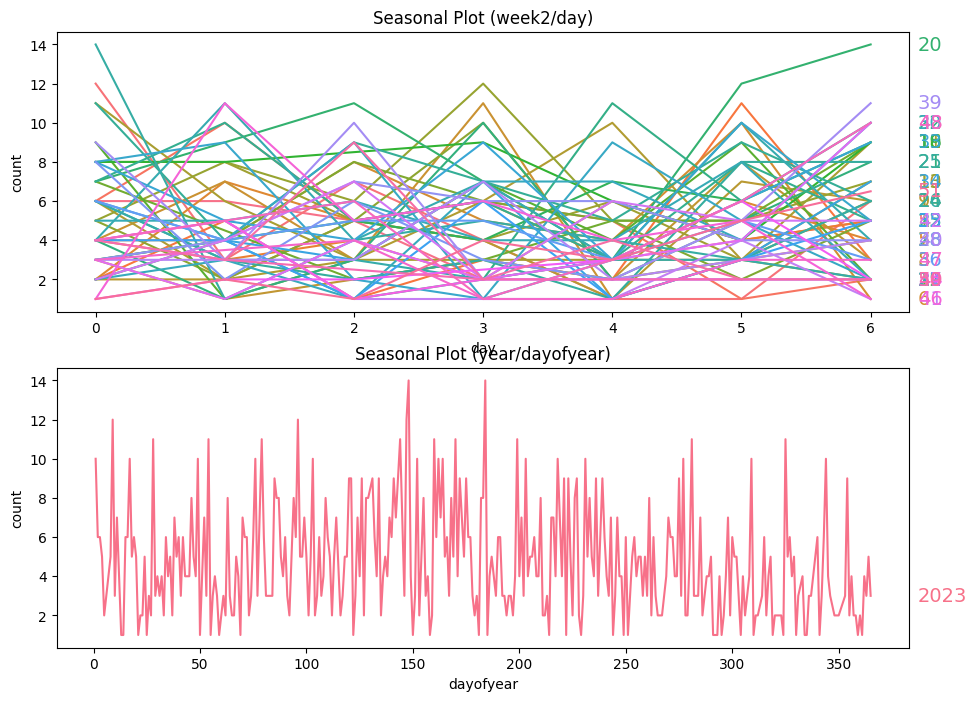

In [ ]:
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])

#limit this to only last year
X = X.loc[X.date.dt.year==2023, ["date", "count"]]

# annotation https://www.kaggle.com/code/ryanholbrook/seasonality
# days within a week
X["day"] = X.date.dt.dayofweek  # the x-axis (freq)
X["week"] = X.date.dt.isocalendar().week  # the seasonal period (period)
X["week2"] = X.week.astype(int)

# days within a year
X["dayofyear"] = X.date.dt.dayofyear
X["year"] = X.date.dt.year

#palette = sns.color_palette("Set1", n_colors=52)
#sns.lineplot(x=X.day, y=X.count, hue=X.week2, palette=palette)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 8))
seasonal_plot(X, y="count", period="week2", freq="day", ax=ax0)
seasonal_plot(X, y="count", period="year", freq="dayofyear", ax=ax1);

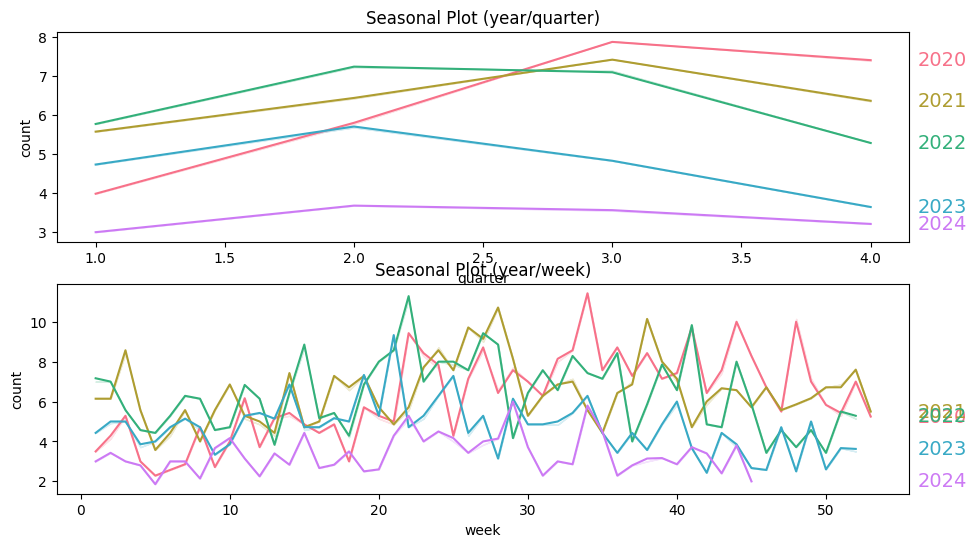

In [ ]:
# Now we are going to look into quartly trends as well as weeks in the year as a sort of "season"
# reset X
del X
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])

# quarters within a year
X["quarter"] = X.date.dt.quarter
X["year"] = X.date.dt.year

# weeks in a year
X["week"] = X.date.dt.isocalendar().week  # the seasonal period (period)
X["week"] = X.week.astype(int)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="count", period="year", freq="quarter", ax=ax0)
seasonal_plot(X, y="count", period="year", freq="week", ax=ax1);

## **Periodogram**
Hunting for variance(or lack ther of) in seasonality.

In [ ]:
# this function borrowed from https://www.kaggle.com/code/ryanholbrook/seasonality
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    ts = ts.to_numpy().squeeze()
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

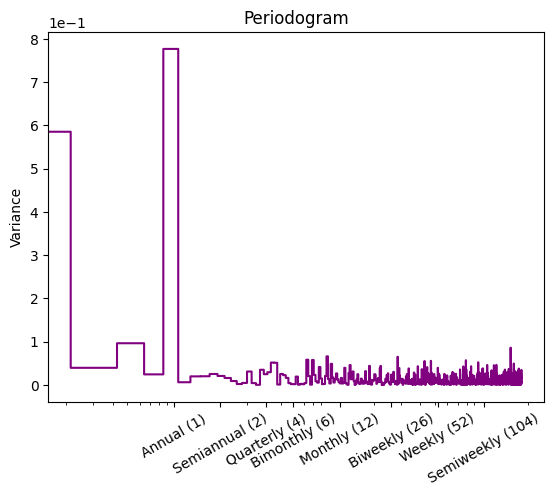

In [ ]:
del X
X = grouped.copy()
X.rename(columns={"date_only":"date"}, inplace=True)
X["date"] = pd.to_datetime(X["date"])
X = X.set_index("date").to_period("D")

plot_periodogram(X)

In [ ]:
fourier = CalendarFourier(freq="YE", order=2)  # 2 sin/cos pairs for (YE)annual seasonality
y = X["count"]
dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

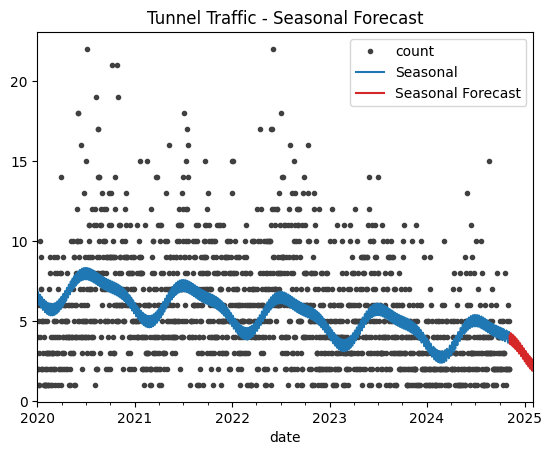

In [ ]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

## **Create Lags**
This section will seek to create lags, which will allow a model to look back at the previous *n* y values, giving the models a little more information on the current goings on.

This may not be the most efficient implementation, but I believe it is a good starting point.

In [ ]:
s = grouped.iloc[:,1]
df = pd.concat([grouped["date_only"], s, s.shift().rename('count_lag1'), s.shift(2).rename('count_lag2')], axis=1)
df.dropna(inplace=True)
df.astype(dtype={"count_lag1":"int","count_lag2":"int"})

,date_only,count,count_lag1,count_lag2
2,2020-01-03,2,2,6
3,2020-01-04,4,2,2
4,2020-01-06,1,4,2
5,2020-01-07,3,1,4
6,2020-01-08,1,3,1
...,...,...,...,...
1656,2024-09-08,2,2,1
1657,2024-09-09,2,2,2
1658,2024-09-10,3,2,2
1659,2024-09-11,1,3,2
